In [1]:
!pip install kaggle
!pip install -q kaggle
!pip install catboost

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from shutil import copyfile
import shutil
from catboost import CatBoostRegressor
from sklearn.svm import NuSVR
import lightgbm

In [3]:
# Upload kagle.json, which is downloaded from 'my account' on kaggle homepage

from google.colab import files
files.upload()

os.getcwd()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 

# shutil.rmtree('/.kaggle')
# os.mkdir('.kaggle')

# copyfile('kaggle.json','root/.kaggle')


Saving kaggle.json to kaggle.json


In [4]:
# get name of competition
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3103           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11036            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4664           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3278           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [5]:
# Download dataset
!kaggle competitions download -c LANL-Earthquake-Prediction --force


  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.5MB/s]
 96% 233M/242M [00:02<00:00, 74.8MB/s]
100% 242M/242M [00:03<00:00, 83.8MB/s]
100% 2.03G/2.03G [00:36<00:00, 50.8MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.9MB/s]


In [6]:
!unzip train.csv.zip


Archive:  train.csv.zip
  inflating: train.csv               


In [7]:
!unzip test.zip


Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [0]:
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows = 6000000)

In [0]:

train_df['time_to_failure'].describe()

count    6.000000e+06
mean     1.350958e+00
std      2.533610e+00
min      7.954798e-04
25%      3.902964e-01
50%      7.796974e-01
75%      1.169098e+00
max      1.154080e+01
Name: time_to_failure, dtype: float64

In [0]:

test_check = pd.read_csv('seg_00030f.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(test_check.head())
print(test_check.shape)
del(test_check)

# Dimension of one test file is (150000,1)

   acoustic_data
0              4
1              0
2             -2
3              0
4              2
(150000, 1)


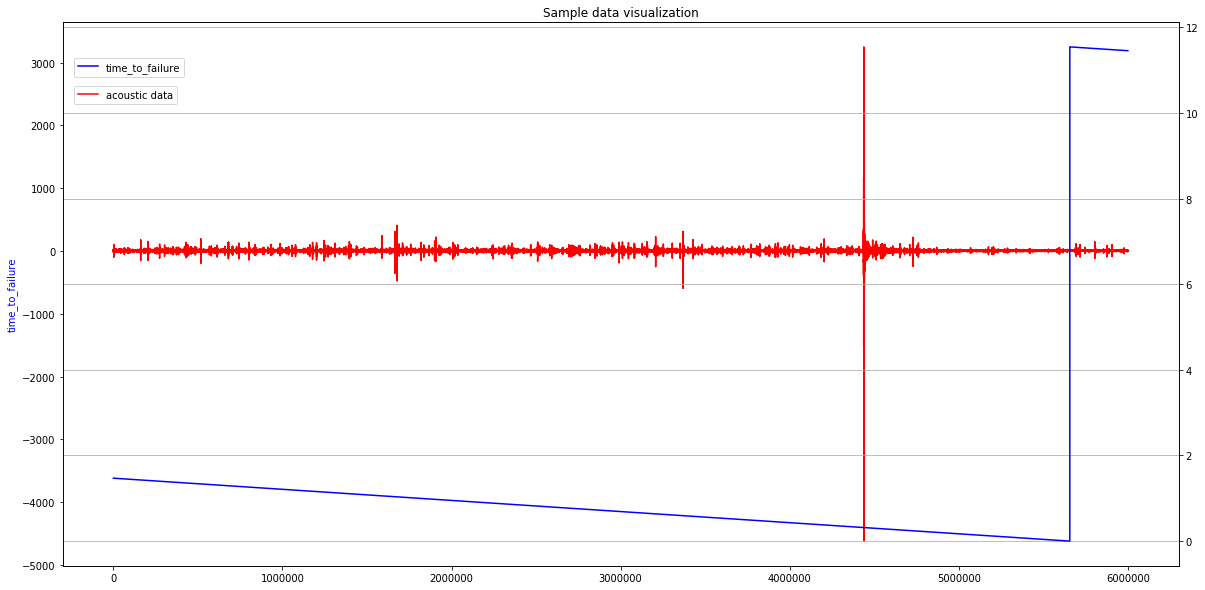

In [0]:
# Visual representation

fig,ax1 = plt.subplots(figsize = (20,10))
plt.title('Sample data visualization')
plt.plot(train_df['acoustic_data'], color = 'r')
ax1.set_ylabel('acoustic data', color = 'r')
plt.legend(['acoustic data'],loc=(0.01, 0.85))

ax2 = ax1.twinx()
plt.plot(train_df['time_to_failure'], color = 'b')
ax1.set_ylabel('time_to_failure', color = 'b')
plt.legend(['time_to_failure'],loc=(0.01, 0.9))
plt.grid(True)


In [0]:
def features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    
    for windows in [10,100]:
        rolling_std = X.rolling(windows).std().dropna().values
        rolling_mean = X.rolling(windows).mean().dropna().values
        
        strain.append(rolling_std.mean())
        strain.append(rolling_std.std())
        strain.append(rolling_std.max())
        strain.append(rolling_std.min())
        strain.append(np.quantile(rolling_std,0.01))
        strain.append(np.quantile(rolling_std,0.10))
        strain.append(np.quantile(rolling_std,0.90))
        strain.append(np.quantile(rolling_std,0.99))
        strain.append(np.mean(np.diff(rolling_std)))
        
        
        strain.append(rolling_mean.mean())
        strain.append(rolling_mean.std())
        strain.append(rolling_mean.max())
        strain.append(rolling_mean.min())
        strain.append(np.quantile(rolling_mean,0.01))
        strain.append(np.quantile(rolling_mean,0.10))
        strain.append(np.quantile(rolling_mean,0.90))
        strain.append(np.quantile(rolling_mean,0.99))
        strain.append(np.mean(np.diff(rolling_mean)))


In [0]:
column_name = []  
column_name.append('X.mean()')
column_name.append('X.std()')
column_name.append('X.min()')
column_name.append('X.max()')
column_name.append('X.kurtosis()')
column_name.append('X.skew()')
column_name.append('np.quantile(X,0.01)')
column_name.append('np.quantile(X,0.05)')
column_name.append('np.quantile(X,0.95)')
column_name.append('np.quantile(X,0.99)')
column_name.append('np.abs(X).max()')
column_name.append('np.abs(X).mean()')
column_name.append('np.abs(X).std()')


for windows in [10,100]:
        
        
        column_name.append('rolling_std.mean()' + '_w =' + str(windows))
        column_name.append('rolling_std.std()'+ '_w =' + str(windows))
        column_name.append('rolling_std.max()'+ '_w =' + str(windows))
        column_name.append('rolling_std.min()'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_std,0.01)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_std,0.10)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_std,0.90)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_std,0.99)'+ '_w =' + str(windows))
        column_name.append('np.mean(np.diff(rolling_std))'+ '_w =' + str(windows))
        
        
        column_name.append('rolling_mean.mean()'+ '_w =' + str(windows))
        column_name.append('rolling_mean.std()'+ '_w =' + str(windows))
        column_name.append('rolling_mean.max()'+ '_w =' + str(windows))
        column_name.append('rolling_mean.min()'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_mean,0.01)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_mean,0.10)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_mean,0.90)'+ '_w =' + str(windows))
        column_name.append('np.quantile(rolling_mean,0.99)'+ '_w =' + str(windows))
        column_name.append('np.mean(np.diff(rolling_mean))'+ '_w =' + str(windows))

In [0]:
# Chunksize = 150000 because that is the exact size of test files

train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    t = features(df['acoustic_data'])
    X_train = X_train.append(t, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    
xtrain = StandardScaler().fit_transform(X_train)    

In [11]:
X_train.columns = column_name
X_train.head()
X_train.shape

(4195, 49)

In [0]:
X_train.to_csv('X_train.csv',index = False)
files.download('X_train.csv')

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_train_X = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
y_train = np.ravel(y_train)

In [0]:
def model(X,Y,a):
    
    if a == 'train':
      
      kf = KFold(n_splits=5, random_state=5, shuffle = True)
      model_1 = RandomForestRegressor(n_estimators=200,criterion='mse',oob_score=True, random_state=0)
      model_3 = CatBoostRegressor(iterations=200,  eval_metric='MAE')
      model_4 = NuSVR(gamma='scale', nu=0.75, C=10.0)

      for (train_index, val_index), i  in zip(kf.split(X,Y),range(1,6)):

          xtrain, xval = X.iloc[train_index], X.iloc[val_index]
          ytrain, yval = Y.iloc[train_index], Y.iloc[val_index]

          model_1.fit(xtrain,ytrain)
          print('rfr - ' + 'fold '+ str(i) + str(model_1.score(xval,yval)))
          
          model_3.fit(xtrain,ytrain)
          print('cat - ' + 'fold '+ str(i) + str(model_3.score(xval,yval)))

          model_4.fit(xtrain,np.ravel(ytrain))
          print('NuSVR - ' + 'fold '+ str(i) + str(model_4.score(xval,yval)))
        
        

    if a == 'test':
      
      y1 = model_1.predict(X)
      y3 = model_3.predict(X)
      y4 = model_4.predict(X)
      
      y = (y1+y3+y4)/4
      
            
        
    
    
    
    

In [54]:
model(scaled_train_X,y_train,'train')

rfr - fold 10.5104615841144039
0:	learn: 5.5219667	total: 12.8ms	remaining: 2.54s
1:	learn: 5.3704077	total: 24.6ms	remaining: 2.44s
2:	learn: 5.2224681	total: 36.5ms	remaining: 2.4s
3:	learn: 5.0797342	total: 48.4ms	remaining: 2.37s
4:	learn: 4.9438128	total: 60ms	remaining: 2.34s
5:	learn: 4.8126565	total: 71.6ms	remaining: 2.31s
6:	learn: 4.6874773	total: 83.8ms	remaining: 2.31s
7:	learn: 4.5671079	total: 95.4ms	remaining: 2.29s
8:	learn: 4.4526893	total: 108ms	remaining: 2.29s
9:	learn: 4.3434368	total: 120ms	remaining: 2.27s
10:	learn: 4.2369250	total: 131ms	remaining: 2.25s
11:	learn: 4.1367463	total: 152ms	remaining: 2.38s
12:	learn: 4.0412847	total: 164ms	remaining: 2.35s
13:	learn: 3.9473291	total: 176ms	remaining: 2.33s
14:	learn: 3.8567048	total: 187ms	remaining: 2.31s
15:	learn: 3.7690348	total: 200ms	remaining: 2.3s
16:	learn: 3.6859290	total: 211ms	remaining: 2.28s
17:	learn: 3.6057410	total: 223ms	remaining: 2.26s
18:	learn: 3.5279236	total: 235ms	remaining: 2.24s
19:	le

In [0]:
#  Processing test data

seg_id = list()
X_test = pd.DataFrame()

for i in sorted(os.listdir(os.getcwd())):
  
  if i[0:3] == 'seg':
    
    temp = pd.read_csv(i, dtype={'acoustic_data': np.int16})
    t = features(temp['acoustic_data'])
    X_test = X_test.append(t,ignore_index = True)
    
    
    seg_id.append(i[0:-4])

X_test.columns = column_name
xtest = StandardScaler().fit_transform(X_test)

del temp,X_test,t

In [0]:
# Prediction and Output

y = model3.predict(xtest)
submission = pd.DataFrame({'seg_id':seg_id,'time_to_failure':list(y)})
submission.to_csv('submission.csv',index = False)
files.download('submission.csv')
